In [1]:
#https://github.com/JustinHeaton/Behavioral-Cloning/blob/master/model.py
import cv2

In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import pandas as pd
import os
import json
from skimage.exposure import adjust_gamma
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from scipy.misc import imresize

Using TensorFlow backend.


In [4]:
# Get steering angles for controlled driving
angles = pd.read_csv('Data/driving_log.csv',header=None)
angles.columns = ('Center Image','Left Image','Right Image','Steering Angle','Throttle','Brake','Speed')
angles = np.array(angles['Steering Angle'])[1:]

In [5]:
angles_unique = np.unique(angles)
angles_unique = angles_unique.astype(np.float32)
angles = angles.astype(np.float32)

In [6]:
len(angles_unique)

124

In [7]:
np.histogram(angles, bins=200, range=(-1,1))

(array([   0,    0,    0,    0,    0,    2,    1,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,
           1,    0,    0,    0,    0,    1,    0,    0,    0,    2,    0,
           0,    0,    0,    0,    2,    0,    2,    0,    0,    0,    0,
           0,    0,    1,    2,    0,    8,    6,    0,    1,    2,    1,
          17,   13,    4,   15,    3,   10,    8,   10,    0,    9,    4,
           5,    9,   14,    9,   43,   38,   31,   18,   10,   20,   36,
          41,   56,    7,    8,   16,   20,   36,   49,  179,   51,   26,
          55,   33,   23,   80,  150,  129,  213,   46,   38,   49,   31,
          79, 4373,   74,   53,   32,  106,   92,   71,   92,   27,  165,
          85,   23,   98,   37,   31,   69,  136,  237,   37,   28,   14,
          25,    5,   11,    8,   14,   26,   36,   12,   10,   37,   17,
          17,    2,   28,   36,   20,   12,    3,    0,    8,    2,    1,
           3,    1,    8,    8,    4, 

In [8]:
# Construct arrays for center, right and left images of controlled driving
images = np.asarray(os.listdir("Data/IMG/"))
#images = images[1:] # To ignore .DS_store on mac
center = np.ndarray(shape=(len(angles), 20, 64, 3))
right = np.ndarray(shape=(len(angles), 20, 64, 3))
left = np.ndarray(shape=(len(angles), 20, 64, 3))


In [9]:
print(len(images))

24108


center_2016_12_01_13_30_48_404.jpg


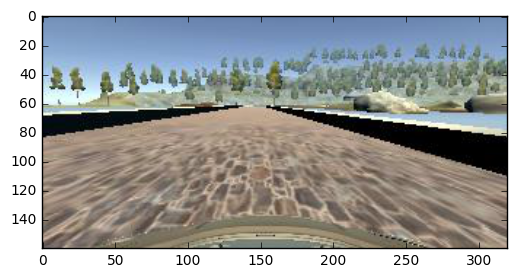

In [10]:
print(images[1])

image_file = os.path.join('Data/IMG', images[100])
img = plt.imread(image_file)

plt.imshow(img)

plt.show()


In [11]:
# Populate controlled driving datasets
# Images are resized to 32x64 to increase training speeds
# The top 12 pixels are cropped off because they contain no useful information for driving behavior
# Final image size to be used in training is 20 x 64 x 3
count = 0
for image in images:
    image_file = os.path.join('Data/IMG', image)
    if image.startswith('center'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        center[count % len(angles)] = imresize(image_data, (32,64,3))[12:,:,:]
    elif image.startswith('right'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        right[count % len(angles)] = imresize(image_data, (32,64,3))[12:,:,:]
    elif image.startswith('left'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        left[count % len(angles)] = imresize(image_data, (32,64,3))[12:,:,:]
    count += 1

In [12]:
# Concatenate all arrays in to combined training dataset and labels

X_train = np.concatenate((center, right, left), axis=0)
y_train = np.concatenate(((angles.astype(np.float32)), (angles.astype(np.float32) - .25), (angles.astype(np.float32) + .25)),axis=0)


In [13]:
# Create a mirror image of the images in the dataset to combat left turn bias
mirror = np.ndarray(shape=(X_train.shape))
count = 0
for i in range(len(X_train)):
    mirror[count] = np.fliplr(X_train[i])
    count += 1
mirror.shape

# Create mirror image labels
mirror_angles = y_train * -1

# Combine regular features/labels with mirror features/labels
X_train = np.concatenate((X_train, mirror), axis=0)
y_train = np.concatenate((y_train, mirror_angles),axis=0)

# Perform train/test split to a create validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.05)

In [14]:
# Establish model architecture
model = Sequential()
model.add(BatchNormalization(axis=1, input_shape=(20,64,3)))
model.add(Convolution2D(16, 3, 3, border_mode='valid', subsample=(2,2), activation='relu'))
model.add(Convolution2D(24, 3, 3, border_mode='valid', subsample=(1,2), activation='relu'))
model.add(Convolution2D(36, 3, 3, border_mode='valid', activation='relu'))
model.add(Convolution2D(48, 2, 2, border_mode='valid', activation='relu'))
model.add(Convolution2D(48, 2, 2, border_mode='valid', activation='relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 20, 64, 3)     80          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 9, 31, 16)     448         batchnormalization_1[0][0]       
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 7, 15, 24)     3480        convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 13, 36)     7812        convolution2d_2[0][0]            
___________________________________________________________________________________________

In [15]:
# Compile model with adam optimizer and learning rate of .0001
adam = Adam(lr=0.0001)
model.compile(loss='mse',
              optimizer=adam)

In [16]:
# Model will save the weights whenever validation loss improves
# checkpoint = ModelCheckpoint(filepath = 'model.h5', verbose = 1, save_best_only=True, monitor='val_loss')

# Discontinue training when validation loss fails to decrease
callback = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# Train model for 20 epochs and a batch size of 128
model.fit(X_train,
        y_train,
        nb_epoch=20,
        verbose=1,
        batch_size=128,
        shuffle=True,
        validation_data=(X_val, y_val),
        callbacks=[callback])

Train on 45805 samples, validate on 2411 samples
Epoch 1/20
45805/45805 [==============================] - 32s - loss: 0.0218 - val_loss: 0.0123
Epoch 2/20
45805/45805 [==============================] - 30s - loss: 0.0123 - val_loss: 0.0109
Epoch 3/20
45805/45805 [==============================] - 30s - loss: 0.0111 - val_loss: 0.0105
Epoch 4/20
45805/45805 [==============================] - 30s - loss: 0.0104 - val_loss: 0.0105
Epoch 5/20
45805/45805 [==============================] - 30s - loss: 0.0100 - val_loss: 0.0100
Epoch 6/20
45805/45805 [==============================] - 30s - loss: 0.0097 - val_loss: 0.0098
Epoch 7/20
45805/45805 [==============================] - 30s - loss: 0.0094 - val_loss: 0.0096
Epoch 8/20
45805/45805 [==============================] - 30s - loss: 0.0092 - val_loss: 0.0095
Epoch 9/20
45805/45805 [==============================] - 30s - loss: 0.0089 - val_loss: 0.0095
Epoch 10/20
45805/45805 [==============================] - 30s - loss: 0.0087 - val_los

In [17]:
model.save_weights("model.h5", True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

In [18]:
#print("Weights Saved")
json_string = model.to_json()
with open('model.json', 'w') as jsonfile:
    json.dump(json_string, jsonfile)
print("Model Saved")

Model Saved
